In [ ]:
# Do this and follow instructions for render to work

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (56.0.0)


In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
import cv2

from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Shape of image:  (400, 600, 3)


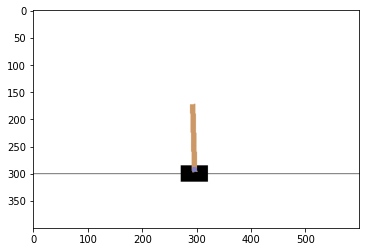

In [ ]:
# Check if render indeed works by plotting initial state
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")
env.reset()

def plot_initial(env):
  img = env.render(mode="rgb_array")
  np_img = np.array(img)

  print('Shape of image: ', np_img.shape)

  plt.imshow(np_img)
  plt.show()

plot_initial(env)

In [ ]:
# Store frames resulting from random actions
def store_frames(env):
  
  epochs = 0

  frames = [] # for animation

  env.reset()

  done = False

  while not done:

    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    
    # Put each rendered frame into dict for animation
    img_frame = np.array(env.render(mode="rgb_array"))
    frames.append(img_frame)
    epochs += 1

  print("Timesteps taken: {}".format(epochs))

  return frames

frames = store_frames(env)

Timesteps taken: 31


In [ ]:
# Make a video sequence from stored frames of the random agent
def make_video(frames):

  size = frames[0].shape # Size of each image in frame
  fps = 12
  out = cv2.VideoWriter('random_agent.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0])) # Assumes RGB, need to only pass (width, height)

  for frame in frames:
      data = frame[:, :, ::-1] # assumes BGR format, so reverse channels
      out.write(data)

  out.release()

make_video(frames)

In [ ]:
# CNN Implementation, using class

# Import packages
import numpy as np
import gym

import time
import random
from collections import deque

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout


In [ ]:
def CNN_agent(image_size, num_actions, dueling):
  # Architecture of the CNN, accepts a stack of 4 images(current state) and returns q value corresponding to that state
  # Inputs:
  # image_size: Size of the input image frames
  # num_actions: Number of actions
  # Outputs:
  # Compiled Architecture of the CNN

  # My own architecture, feel free to modify to the actual implementation
  learning_rate = 0.001

  input_tensor = keras.Input(shape=image_size)

  main_stream = Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(input_tensor)
  main_stream = Conv2D(filters = 32, kernel_size=(3,3), padding="same", activation="relu")(main_stream)
  main_stream = MaxPooling2D((2,2))(main_stream)

  main_stream = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(main_stream)
  main_stream = Conv2D(filters = 64, kernel_size=(3,3), padding="same", activation="relu")(main_stream)
  main_stream = MaxPooling2D((2,2))(main_stream)

  main_stream = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(main_stream)
  main_stream = Conv2D(filters = 128, kernel_size=(3,3), padding="same", activation="relu")(main_stream)
  main_stream = MaxPooling2D((2,2))(main_stream)

  main_stream = Conv2D(filters=128, kernel_size=(5,5), strides=2, padding="same", activation="relu")(main_stream)
  main_stream = Dropout(rate=0.2)(main_stream)

  main_stream = Flatten()(main_stream)

  main_stream = Dense(units=256, activation="relu", kernel_initializer="he_uniform")(main_stream)
  main_stream = Dense(units=128, activation="relu", kernel_initializer="he_uniform")(main_stream)

  if dueling: # Add value and advantage stream if the dueling flag is set to true

    value_stream = Dense(units=64, activation="relu", kernel_initializer="he_uniform")(main_stream)
    V = Dense(units=1, activation="linear", kernel_initializer="he_uniform")(value_stream)

    advantage_stream = Dense(units=64, activation="relu", kernel_initializer="he_uniform")(main_stream)
    A = Dense(units=num_actions, activation="linear", kernel_initializer="he_uniform")(advantage_stream)

    out_tensor = V + tf.subtract(A, tf.reduce_mean(A, axis=1, keepdims=True))

  else:

    out_tensor = Dense(units=num_actions, activation="linear", kernel_initializer="he_uniform")(main_stream)

  model = keras.Model(inputs=input_tensor, outputs=out_tensor)

  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


In [ ]:
class CNN_DQN_agent:

  def __init__(self, env_name):
    # Parameters
    # env_name: Name of the game we are playing

    self.game_name = env_name # Name of the game we are playing
    self.game = gym.make(env_name) # Create the game environment

    self.double_dqn = False # flag for Double DQN learning (slows down a lot)
    self.dueling = False # Flag for using dueling architecture

    self.min_epsilon = 0.01 # At the minimum we explore 1 % of the time
    self.max_epsilon = 1 # Start with 100% exploration
    self.epsilon = self.max_epsilon # Start with max exploration and decay exponentially with # of episodes
    self.decay = 0.01 # decay rate (exponential)

    # We reduce our original RGB rendered image to a grayscale image of the size given below
    self.img_row = 160 
    self.img_col = 210
    self.num_frames = 4 # Number of frames to stack

    self.image_frames = np.zeros((self.img_row, self.img_col, self.num_frames)) # Stores the current stack of 4 frames (refered to as image state)

    self.image_size = (self.img_row, self.img_col, self.num_frames) # Create tuple of image state size
    self.num_actions = self.game.action_space.n # Number of actions

    # Replay memory
    self.memory_len = 50000 
    self.replay_memory = deque(maxlen=self.memory_len)

    self.gamma = 0.618 # Discount factor
    self.alpha = 0.7 # Learning rate of Q-learning

    self.batch_size = 8 # Since its images, use a smaller batchsize to train

    # Initialize networks
    self.main_net = CNN_agent(self.image_size, self.num_actions, self.dueling)
    self.target_net = CNN_agent(self.image_size, self.num_actions, self.dueling)
    self.target_net.set_weights(self.main_net.get_weights()) 

    self.train_episodes = 3000

    self.num_steps_main = 4
    self.num_update_target = 100

    self.steps = 0

    self.all_rewards = []

  # Function that converts the original RGB rendered image of the current state (which is 400x600x3) to self.image_size
  def render_image(self):

    cur_img_state = self.game.render(mode="rgb_array") # Render current state of the game environment
    cur_img_gray = cv2.cvtColor(cur_img_state, cv2.COLOR_RGB2GRAY) # RGB to gray using cv2
    cur_img_resized = cv2.resize(cur_img_gray, (self.img_col, self.img_row), interpolation=cv2.INTER_CUBIC) # resize uses (img_col, img_row)

    self.image_frames = np.roll(self.image_frames, shift=1, axis=2) # A circular shift of 1 applied along the frame axis
    self.image_frames[:, :, 0] = cur_img_resized # Overwrite the oldest frame with the current resized image

    return self.image_frames

  # Add batch axis to make predictions for single element states
  def add_batch_axis(self, cur_img_state):
    
    cur_img_expanded = np.expand_dims(cur_img_state, axis=0)
    
    return cur_img_expanded

  # Select action to take by argmax over current Q-value as predicted by main_net (Exploitation)
  def select_action(self, cur_img_state):

    cur_img_expanded = self.add_batch_axis(cur_img_state)
    q_val_cur = np.squeeze(self.main_net.predict(cur_img_expanded))
    selected_action = np.argmax(q_val_cur)

    return selected_action

  # Train the main net (The only difference here is that our states are stacked frames)
  def train_main_net(self):

    min_experience = 1000

    if len(self.replay_memory) < min_experience:
      
      return

    num_experiences = 128

    random_experiences = random.sample(self.replay_memory, num_experiences)
    cur_img_states = np.array([experience[0] for experience in random_experiences])
    next_img_states = np.array([experience[3] for experience in random_experiences])

    q_vals_cur = self.main_net.predict(cur_img_states)
    q_vals_next = self.target_net.predict(next_img_states)

    img_states = []
    target_q_vals = []

    for i, (state, action, reward, next_state, done) in enumerate(random_experiences):

      if done:

        q_cur_state = reward

      else:

        if self.double_dqn:

          expand_next_state = add_batch_axis(next_state)
          sel_action_main = np.argmax(np.squeeze(self.main_net.predict(expand_next_state)))

          q_val_target = q_vals_next[i]

          q_cur_state = reward + self.gamma*q_val_target[sel_action_main]

        else:

          q_cur_state = reward + self.gamma*np.max(q_vals_next[i])

      q_val_cur = q_vals_cur[i]

      if self.double_dqn:

        q_val_cur[action] = q_cur_state

      else:

        q_val_cur[action] = (1-self.alpha)*q_val_cur[action] + self.alpha*q_cur_state

      img_states.append(state)
      target_q_vals.append(q_val_cur)
    
    X = np.array(img_states)
    y = np.array(target_q_vals)

    self.main_net.fit(X, y, batch_size=self.batch_size, shuffle=True)

  # Trains the agent over a specified number of episodes
  def train_on_game(self):

    for eps in range(self.train_episodes):

      cur_state = self.game.reset() # Reset environment 
      cur_img_state = self.render_image() # Add image of initial state to stack of frames

      episode_reward = 0
      
      done = False 

      while not done:

        u = np.random.uniform(0, 1)

        if u < self.epsilon: # Explore

          cur_action = self.game.action_space.sample()

        else: # Exploit

          cur_action = self.select_action(cur_img_state)

        next_state, reward, done, info = self.game.step(cur_action)
        next_img_state = self.render_image() # Add image of the next state to the stack of frames

        self.replay_memory.append([cur_img_state, cur_action, reward, next_img_state, done])

        self.steps += 1
        episode_reward += reward

        if self.steps % self.num_steps_main == 0 or done:

          self.train_main_net()

        if self.steps % self.num_update_target == 0:
          
          print('Copying weights from main to target')
          self.target_net.set_weights(self.main_net.get_weights())

        cur_img_state = next_img_state

      if self.steps % evaluate_steps == 0:

        # 5 times
        # Evaluate by using greedy actions
        # store each frame
        # 

      self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay*eps)

      # Print some statistics to check if there's learning
      print('Epsiode {} statistics: '.format(eps+1))
      print('Reward obtained: ', episode_reward)

      self.all_rewards.append(episode_reward)


    
env_name = "CartPole-v1"
agent = CNN_DQN_agent(env_name)
agent.train_on_game()

Epsiode 1 statistics: 
Reward obtained:  17.0
Epsiode 2 statistics: 
Reward obtained:  12.0
Epsiode 3 statistics: 
Reward obtained:  40.0
Epsiode 4 statistics: 
Reward obtained:  14.0
Copying weights from main to target
Epsiode 5 statistics: 
Reward obtained:  22.0
Epsiode 6 statistics: 
Reward obtained:  14.0
Epsiode 7 statistics: 
Reward obtained:  12.0
Epsiode 8 statistics: 
Reward obtained:  12.0
Epsiode 9 statistics: 
Reward obtained:  19.0
Epsiode 10 statistics: 
Reward obtained:  23.0
Copying weights from main to target
Epsiode 11 statistics: 
Reward obtained:  16.0
Epsiode 12 statistics: 
Reward obtained:  10.0
Epsiode 13 statistics: 
Reward obtained:  14.0
Epsiode 14 statistics: 
Reward obtained:  18.0
Epsiode 15 statistics: 
Reward obtained:  36.0
Copying weights from main to target
Epsiode 16 statistics: 
Reward obtained:  32.0
Epsiode 17 statistics: 
Reward obtained:  22.0
Epsiode 18 statistics: 
Reward obtained:  13.0
Epsiode 19 statistics: 
Reward obtained:  12.0
Epsiode 

In [ ]:
plt.plot(agent.all_rewards)
plt.title('Rewards obtained in each episode')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.show()

NameError: ignored